# Timeseries Forecasting

This notebook explains how to use `tsfresh` in time series foreacasting.
Make sure you also read through the [documentation](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) to learn more on this feature.

It is basically a copy of the other time series forecasting notebook, but this time using more than one 
stock.
This is conceptionally not much different, but the pandas multi-index magic is a bit advanced :-)

We will use the Google, Facebook and Alphabet stock.
Please find all documentation in the other notebook.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

try:
    import pandas_datareader.data as web
except ImportError:
    print("You need to install the pandas_datareader. Run pip install pandas_datareader.")

from sklearn.ensemble import AdaBoostRegressor

## Reading the data

In [3]:
df = web.DataReader(['A', "AAPL", "GOOGL"], 'stooq')["High"]
df.head()

Symbols,A,AAPL,GOOGL
Date,,,
2022-09-02,130.270,160.362,110.740
2022-09-01,129.110,158.420,110.445
2022-08-31,130.230,160.580,110.850
2022-08-30,129.019,162.560,110.500
2022-08-29,129.350,162.900,110.950


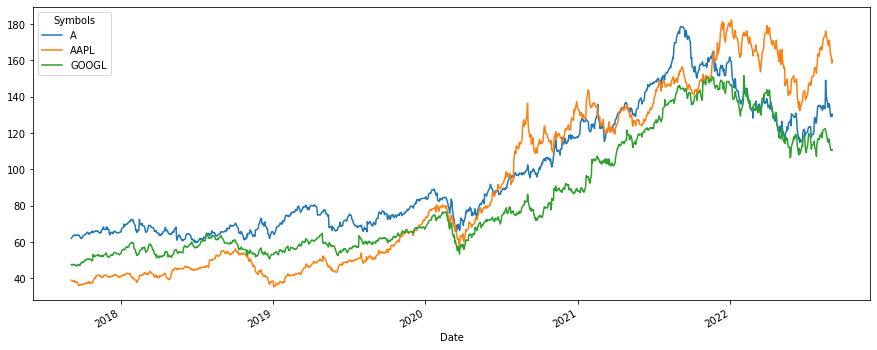

In [4]:
plt.figure(figsize=(15, 6))
df.plot(ax=plt.gca())
plt.show()

This time we need to make sure to preserve the stock symbol information while reordering:

In [5]:
df_melted = df.copy()
df_melted["date"] = df_melted.index
df_melted = df_melted.melt(id_vars="date", value_name="high").sort_values(["Symbols", "date"])
df_melted = df_melted[["Symbols", "date", "high"]]

df_melted

,Symbols,date,high
1258,A,2017-09-05,62.0361
1257,A,2017-09-06,62.3546
1256,A,2017-09-07,62.7728
1255,A,2017-09-08,63.1911
1254,A,2017-09-11,63.7591
...,...,...,...
2522,GOOGL,2022-08-29,110.9500
2521,GOOGL,2022-08-30,110.5000
2520,GOOGL,2022-08-31,110.8500
2519,GOOGL,2022-09-01,110.4450


## Create training data sample

In [6]:
df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="date",
                             max_timeshift=20, min_timeshift=5)

C:\Users\bisha\AppData\Roaming\Python\Python38\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 20/20 [00:13<00:00,  1.54it/s]


In [15]:
df_rolled.head(200)

,Symbols,date,high,id
0,A,2017-09-05,62.0361,"(A, 2017-09-12 00:00:00)"
1,A,2017-09-06,62.3546,"(A, 2017-09-12 00:00:00)"
2,A,2017-09-07,62.7728,"(A, 2017-09-12 00:00:00)"
3,A,2017-09-08,63.1911,"(A, 2017-09-12 00:00:00)"
4,A,2017-09-11,63.7591,"(A, 2017-09-12 00:00:00)"
...,...,...,...,...
585,A,2017-09-05,62.0361,"(A, 2017-10-03 00:00:00)"
586,A,2017-09-06,62.3546,"(A, 2017-10-03 00:00:00)"
587,A,2017-09-07,62.7728,"(A, 2017-10-03 00:00:00)"
588,A,2017-09-08,63.1911,"(A, 2017-10-03 00:00:00)"


## Extract Features

In [8]:
X = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="date", column_value="high", 
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


In [9]:
X

high__variance_larger_than_standard_deviation  \
A     2017-09-12                                            0.0   
      2017-09-13                                            0.0   
      2017-09-14                                            0.0   
      2017-09-15                                            0.0   
      2017-09-18                                            0.0   
...                                                         ...   
GOOGL 2022-08-29                                            1.0   
      2022-08-30                                            1.0   
      2022-08-31                                            1.0   
      2022-09-01                                            1.0   
      2022-09-02                                            1.0   

                  high__has_duplicate_max  high__has_duplicate_min  \
A     2017-09-12                      0.0                      0.0   
      2017-09-13                      0.0                      0.0   
      2017-09-14                      0.0                      0.0   
      2017-09-15                      0.0                      0.0   
      2017-09-18                      0.0                      0.0   
...                                   ...                      ...   
GOOGL 2022-08-29                      0.0                      0.0   
      2022-08-30                      0.0                      0.0   
      2022-08-31                      0.0                      0.0   
      2022-09-01                      0.0                      0.0   
      2022-09-02                      0.0                      0.0   

                  high__has_duplicate  high__sum_values  high__abs_energy  \
A     2017-09-12                  0.0          378.0195      23819.287490   
      2017-09-13                  0.0          441.7307      27878.404495   
      2017-09-14                  0.0          505.1044      31894.630347   
      2017-09-15                  0.0          568.7287      35942.681897   
      2017-09-18                  0.0          632.5167      40011.590841   
...                               ...               ...               ...   
GOOGL 2022-08-29                  1.0         2484.3356     294086.674851   
      2022-08-30                  0.0         2478.1156     292673.366451   
      2022-08-31                  0.0         2472.6156     291423.766451   
      2022-09-01                  0.0         2464.4406     289551.160076   
      2022-09-02                  0.0         2456.4006     287705.819276   

                  high__mean_abs_change  high__mean_change  \
A     2017-09-12               0.373940           0.373940   
      2017-09-13               0.344050           0.279183   
      2017-09-14               0.343114           0.191086   
      2017-09-15               0.331550           0.198525   
      2017-09-18               0.312900           0.194656   
...                                 ...                ...   
GOOGL 2022-08-29               1.440940          -0.288500   
      2022-08-30               1.444940          -0.292500   
      2022-08-31               1.348940          -0.388500   
      2022-09-01               1.361190          -0.416750   
      2022-09-02               1.342220          -0.368280   

                  high__mean_second_derivative_central  high__median  ...  \
A     2017-09-12                             -0.021475      62.98195  ...   
      2017-09-13                             -0.051310      63.19110  ...   
      2017-09-14                             -0.054667      63.28240  ...   
      2017-09-15                             -0.004850      63.37370  ...   
      2017-09-18                             -0.009675      63.49900  ...   
...                                                ...           ...  ...   
GOOGL 2022-08-29                             -0.100000     118.62000  ...   
      2022-08-30                             -0.071579     118.62000  ...   
      202

We make the data a bit easier to work with by giving them a multi-index instead ot the tuple index:

In [10]:
# split up the two parts of the index and give them proper names
X = X.set_index([X.index.map(lambda x: x[0]), X.index.map(lambda x: x[1])], drop=True)
X.index.names = ["Symbols", "last_date"]

In [11]:
X.head()

high__variance_larger_than_standard_deviation  \
Symbols last_date                                                   
A       2017-09-12                                            0.0   
        2017-09-13                                            0.0   
        2017-09-14                                            0.0   
        2017-09-15                                            0.0   
        2017-09-18                                            0.0   

                    high__has_duplicate_max  high__has_duplicate_min  \
Symbols last_date                                                      
A       2017-09-12                      0.0                      0.0   
        2017-09-13                      0.0                      0.0   
        2017-09-14                      0.0                      0.0   
        2017-09-15                      0.0                      0.0   
        2017-09-18                      0.0                      0.0   

                    high__has_duplicate  high__sum_values  high__abs_energy  \
Symbols last_date                                                             
A       2017-09-12                  0.0          378.0195      23819.287490   
        2017-09-13                  0.0          441.7307      27878.404495   
        2017-09-14                  0.0          505.1044      31894.630347   
        2017-09-15                  0.0          568.7287      35942.681897   
        2017-09-18                  0.0          632.5167      40011.590841   

                    high__mean_abs_change  high__mean_change  \
Symbols last_date                                              
A       2017-09-12               0.373940           0.373940   
        2017-09-13               0.344050           0.279183   
        2017-09-14               0.343114           0.191086   
        2017-09-15               0.331550           0.198525   
        2017-09-18               0.312900           0.194656   

                    high__mean_second_derivative_central  high__median  ...  \
Symbols last_date                                                       ...   
A       2017-09-12                             -0.021475      62.98195  ...   
        2017-09-13                             -0.051310      63.19110  ...   
        2017-09-14                             -0.054667      63.28240  ...   
        2017-09-15                             -0.004850      63.37370  ...   
        2017-09-18                             -0.009675      63.49900  ...   

                    high__permutation_entropy__dimension_6__tau_1  \
Symbols last_date                                                   
A       2017-09-12                                      -0.000000   
        2017-09-13                                       0.693147   
        2017-09-14                                       1.098612   
        2017-09-15                                       1.386294   
        2017-09-18                                       1.609438   

                    high__permutation_entropy__dimension_7__tau_1  \
Symbols last_date                                                   
A       2017-09-12                                       2.708050   
        2017-09-13                                      -0.000000   
        2017-09-14                                       0.693147   
        2017-09-15                                       1.098612   
        2017-09-18                                       1.386294   

                    high__query_similarity_count__query_None__threshold_0.0  \
Symbols last_date                                                             
A       2017-09-12                                                0.0         
        2017-09-13                                                0.0         
        2017-09-14                                                0.0         
        2017-09-15                                                0.0         
        2017-09-18              

Our `(AAPL, 2020-07-14 00:00:00)` is also in the data again:

In [12]:
X.loc["AAPL", pd.to_datetime('2020-07-14')]

high__variance_larger_than_standard_deviation                1.000000
high__has_duplicate_max                                      0.000000
high__has_duplicate_min                                      0.000000
high__has_duplicate                                          0.000000
high__sum_values                                          1912.213900
                                                             ...     
high__matrix_profile__feature_"mean"__threshold_0.98         1.993080
high__matrix_profile__feature_"median"__threshold_0.98       1.763901
high__matrix_profile__feature_"25"__threshold_0.98           1.400200
high__matrix_profile__feature_"75"__threshold_0.98           2.415991
high__mean_n_absolute_max__number_of_maxima_7               94.893329
Name: (AAPL, 2020-07-14 00:00:00), Length: 789, dtype: float64

Just to repeat: the features in this row were only calculated using the time series values of `AAPL` up to and including `2015-07-15` and the last 20 days.

## Prediction

The next line might look like magic if you are not used to pandas transformations, but what it does is:

for each stock symbol separately:
* sort by date
* take the high value
* shift 1 time step in the future
* bring into the same multi-index format as `X` above

In [13]:
y = df_melted.groupby("Symbols").apply(lambda x: x.set_index("date")["high"].shift(-1)).T.unstack()

Quick consistency test:

In [19]:
y["AAPL", pd.to_datetime("2020-07-13")], df.loc[pd.to_datetime("2020-07-14"), "AAPL"]

(95.9208, 95.9208)

In [20]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

The splitting into train and test samples workes in principle the same as with a single identifier, but this time we have a multi-index symbol-date, so the `loc` call looks a bit more complicated:

In [21]:
X_train = X.loc[(slice(None), slice(None, "2018")), :]
X_test = X.loc[(slice(None), slice("2019", "2020")), :]

y_train = y.loc[(slice(None), slice(None, "2018"))]
y_test = y.loc[(slice(None), slice("2019", "2020"))]

In [22]:
X_train_selected = select_features(X_train, y_train)

We are training a regressor for each of the stocks separately

In [23]:
adas = {stock: AdaBoostRegressor() for stock in ["AAPL", "F", "GOOGL"]}

for stock, ada in adas.items():
    ada.fit(X_train_selected.loc[stock], y_train.loc[stock])

Now lets check again how good our prediction is:

In [24]:
X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.concat({
    stock: pd.Series(adas[stock].predict(X_test_selected.loc[stock]), index=X_test_selected.loc[stock].index)
    for stock in adas.keys()
})
y_pred.index.names = ["Symbols", "last_date"]

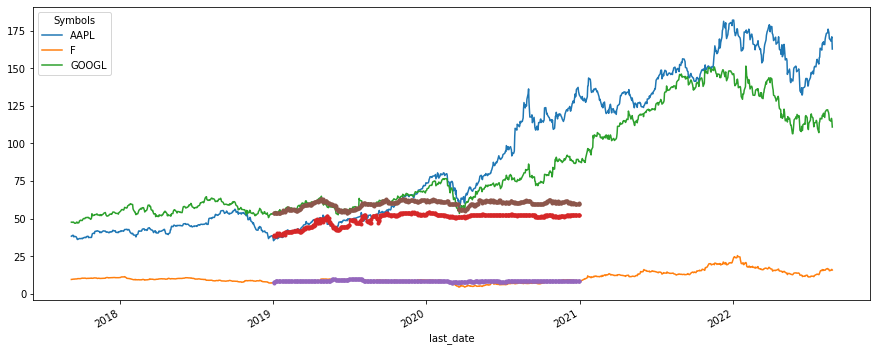

In [25]:
plt.figure(figsize=(15, 6))

y.unstack("Symbols").plot(ax=plt.gca())
y_pred.unstack("Symbols").plot(ax=plt.gca(), legend=None, marker=".")